In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.ma.extras import average

In [65]:
# 한글 폰트 설정
plt.rcParams['font.family'] = 'AppleGothic'
# 마이너스 기호 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False

In [3]:
import os
print(os.getcwd())

/Users/yun-iseo/Workspaces/SKN14-2nd-5Team/YiseoY


# 데이터셋 준비

In [29]:
customers_df = pd.read_csv('data/olist_customers_dataset.csv')
orders_df = pd.read_csv('data/olist_orders_dataset.csv')
order_payments_df = pd.read_csv('data/olist_order_payments_dataset.csv')
order_reviews_df = pd.read_csv('data/olist_order_reviews_dataset.csv')

print(customers_df.shape, orders_df.shape, order_payments_df.shape, order_reviews_df.shape)

(99441, 5) (99441, 8) (103886, 5) (99224, 7)


## RFM-score 기반 라벨 생성
- 이탈: 1
- 활성: 0

In [6]:
orders_df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [47]:
# customer_unique_id 병합
orders_customers_merged = pd.merge(
    orders_df,
    customers_df[['customer_id', 'customer_unique_id']],
    on='customer_id',
    how='left'
)

# orders_customers_merged.head()
orders_customers_merged['customer_unique_id'].nunique()

96096

In [8]:
order_payments_df.head()

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45


In [46]:
# payment_value 병합
payments_orders_customers_merged = pd.merge(
    order_payments_df,
    orders_customers_merged[['order_id', 'customer_unique_id', 'order_purchase_timestamp']],
    on='order_id',
    how='left'
)

# payments_orders_customers_merged.info()
payments_orders_customers_merged['customer_unique_id'].nunique()

96095

In [48]:
# 두 컬럼의 고유 ID 집합 생성
ids_1 = set(orders_customers_merged['customer_unique_id'].unique())
ids_2 = set(payments_orders_customers_merged['customer_unique_id'].unique())

# 차집합을 통해 누락된 ID 찾기
missing_in_payments = ids_1 - ids_2  # orders_customers_merged에는 있지만 payments에는 없는 경우
missing_in_orders = ids_2 - ids_1    # 반대 경우도 확인 가능

# 출력
print("payments_orders_customers_merged에 없는 ID:", missing_in_payments)
print("orders_customers_merged에 없는 ID:", missing_in_orders)

payments_orders_customers_merged에 없는 ID: {'830d5b7aaa3b6f1e9ad63703bec97d23'}
orders_customers_merged에 없는 ID: set()


In [49]:
orders_customers_merged[orders_customers_merged['customer_unique_id'] == '830d5b7aaa3b6f1e9ad63703bec97d23']

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id
30710,bfbd0f9bdef84302105ad712db648a6c,86dc2ffce2dfff336de2f386a786e574,delivered,2016-09-15 12:16:38,2016-09-15 12:16:38,2016-11-07 17:11:53,2016-11-09 07:47:38,2016-10-04 00:00:00,830d5b7aaa3b6f1e9ad63703bec97d23


In [55]:
order_payments_df[order_payments_df['order_id'] == 'bfbd0f9bdef84302105ad712db648a6c']

,order_id,payment_sequential,payment_type,payment_installments,payment_value


In [10]:
rfm_df = payments_orders_customers_merged.groupby('customer_unique_id').agg({
    'order_purchase_timestamp': 'max',
    'order_id': pd.Series.nunique,
    'payment_value': 'sum'
})
rfm_df = rfm_df.rename(columns={
    'order_purchase_timestamp': 'Recency', # 최근 구매 경과일
    'order_id': 'Frequency', # 구매 빈도
    'payment_value': 'Monetary' # 총 구매금액
})

rfm_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 96095 entries, 0000366f3b9a7992bf8c76cfdf3221e2 to ffffd2657e2aad2907e67c3e9daecbeb
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Recency    96095 non-null  object 
 1   Frequency  96095 non-null  int64  
 2   Monetary   96095 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 2.9+ MB


In [11]:
# 1. 날짜형으로 변환
rfm_df['Recency'] = pd.to_datetime(rfm_df['Recency'])

# 2. max_date도 자동으로 datetime으로 저장됨
max_date = rfm_df['Recency'].max()

# 3. 날짜 차이 계산 (timedelta)
rfm_df['Recency'] = max_date - rfm_df['Recency']

rfm_df.head()

,Recency,Frequency,Monetary
customer_unique_id,,,
0000366f3b9a7992bf8c76cfdf3221e2,160 days 06:33:51,1,141.90
0000b849f77a49e4a4ce2b2a4ca5be3f,163 days 06:18:51,1,27.19
0000f46a3911fa3c0805444483337064,585 days 20:25:15,1,86.22
0000f6ccb0745a6a4b88665a16c9f078,369 days 21:00:37,1,43.62
0004aac84e0df4da2b147fca70cf8255,336 days 21:44:36,1,196.89


In [12]:
rfm_df['Recency'] = rfm_df['Recency'].apply(lambda x: x.days + 1)
rfm_df.head()

,Recency,Frequency,Monetary
customer_unique_id,,,
0000366f3b9a7992bf8c76cfdf3221e2,161,1,141.90
0000b849f77a49e4a4ce2b2a4ca5be3f,164,1,27.19
0000f46a3911fa3c0805444483337064,586,1,86.22
0000f6ccb0745a6a4b88665a16c9f078,370,1,43.62
0004aac84e0df4da2b147fca70cf8255,337,1,196.89


In [13]:
# 구간 설정 및 범주 이름 지정
bins = [0, 2, 5, float('inf')]  # 0~2: low, 3~5: mid, 6~: high
labels = ['low', 'mid', 'high']

# 구간화
rfm_df['Frequency_level'] = pd.cut(rfm_df['Frequency'], bins=bins, labels=labels)

rfm_df.head()

,Recency,Frequency,Monetary,Frequency_level
customer_unique_id,,,,
0000366f3b9a7992bf8c76cfdf3221e2,161,1,141.90,low
0000b849f77a49e4a4ce2b2a4ca5be3f,164,1,27.19,low
0000f46a3911fa3c0805444483337064,586,1,86.22,low
0000f6ccb0745a6a4b88665a16c9f078,370,1,43.62,low
0004aac84e0df4da2b147fca70cf8255,337,1,196.89,low


In [14]:
# 매핑 딕셔너리 정의
f_score_map = {
    'low': 1,
    'mid': 3,
    'high': 5
}

# Categorical 컬럼을 문자열로 변환 후 매핑
rfm_df['F_score'] = rfm_df['Frequency_level'].astype(str).map(f_score_map).fillna(2).astype(int)

In [15]:
# 분위수 구간 계산 (NaN 발생 대비 + 분위수 구간 부족 대비)
for col in ['Recency', 'Monetary']:
    try:
        rfm_df[col[0] + '_quantile'] = pd.qcut(
            rfm_df[col],
            5,
            labels=False,
            duplicates='drop'
        )
    except ValueError:
        # 전부 동일하거나 분위수 계산 불가한 경우 → 값 전체를 중간값으로 처리
        rfm_df[col[0] + '_quantile'] = 2

# NaN이 생긴 경우 기본값 2로 대체
rfm_df[['R_quantile', 'M_quantile']] = rfm_df[['R_quantile', 'M_quantile']].fillna(2)

# RFM 점수 계산
rfm_df['R_score'] = (5 - rfm_df['R_quantile']).astype(int)  # Recency는 낮을수록 높게
rfm_df['M_score'] = (1 + rfm_df['M_quantile']).astype(int)

# 최종 RFM Score 조합
rfm_df['RFM_score'] = (
    rfm_df['R_score'].astype(str) +
    rfm_df['F_score'].astype(str) +
    rfm_df['M_score'].astype(str)
)

# 결과 출력
print(rfm_df[['Recency', 'Frequency', 'Monetary', 'R_score', 'F_score', 'M_score', 'RFM_score']])

                                  Recency  Frequency  Monetary  R_score  \
customer_unique_id                                                        
0000366f3b9a7992bf8c76cfdf3221e2      161          1    141.90        4   
0000b849f77a49e4a4ce2b2a4ca5be3f      164          1     27.19        4   
0000f46a3911fa3c0805444483337064      586          1     86.22        1   
0000f6ccb0745a6a4b88665a16c9f078      370          1     43.62        2   
0004aac84e0df4da2b147fca70cf8255      337          1    196.89        2   
...                                   ...        ...       ...      ...   
fffcf5a5ff07b0908bd4e2dbc735a684      496          1   2067.42        1   
fffea47cd6d3cc0a88bd621562a9d061      311          1     84.58        3   
ffff371b4d645b6ecea244b27531430a      618          1    112.46        1   
ffff5962728ec6157033ef9805bacc48      169          1    133.69        4   
ffffd2657e2aad2907e67c3e9daecbeb      533          1     71.56        1   

                        

In [16]:
print(rfm_df['R_score'].value_counts(), '\n')
print(rfm_df['F_score'].value_counts(), '\n')
print(rfm_df['M_score'].value_counts(), '\n')

R_score
5    19324
2    19300
4    19299
1    19129
3    19043
Name: count, dtype: int64 

F_score
1    95843
3      241
5       11
Name: count, dtype: int64 

M_score
3    19222
1    19221
2    19219
5    19219
4    19214
Name: count, dtype: int64 



In [17]:
def classify_churn(row):
    if row['R_score'] <= 2 and row['F_score'] <= 2:
        return 1
    else:
        return 0

# 이탈 여부 태깅
rfm_df['churn'] = rfm_df.apply(classify_churn, axis=1)

In [18]:
rfm_df = rfm_df.reset_index()
rfm_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96095 entries, 0 to 96094
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   customer_unique_id  96095 non-null  object  
 1   Recency             96095 non-null  int64   
 2   Frequency           96095 non-null  int64   
 3   Monetary            96095 non-null  float64 
 4   Frequency_level     96095 non-null  category
 5   F_score             96095 non-null  int64   
 6   R_quantile          96095 non-null  int64   
 7   M_quantile          96095 non-null  int64   
 8   R_score             96095 non-null  int64   
 9   M_score             96095 non-null  int64   
 10  RFM_score           96095 non-null  object  
 11  churn               96095 non-null  int64   
dtypes: category(1), float64(1), int64(8), object(2)
memory usage: 8.2+ MB


In [ ]:
churn_counts = rfm_df['churn'].value_counts().sort_index()
total = churn_counts.sum()

plt.figure(figsize=(6,4))
ax = sns.barplot(x=churn_counts.index, y=churn_counts.values, color='skyblue')

plt.xticks([0,1], ['Active (0)', 'Churned (1)'])
plt.xlabel('Churn')
plt.ylabel('Number of Customers')
plt.title('Distribution of Churn Status')

# 막대 위에 비율 표시
for i, count in enumerate(churn_counts.values):
    percentage = count / total * 100
    ax.text(i, count + total*0.01, f'{percentage:.1f}%', ha='center')

plt.show()

## 배송처리

In [23]:
orders_customers_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 9 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
 8   customer_unique_id             99441 non-null  object
dtypes: object(9)
memory usage: 6.8+ MB


In [25]:
# 데이터타입 변환
orders_customers_merged['order_delivered_customer_date'] = pd.to_datetime(orders_customers_merged['order_delivered_customer_date'])
orders_customers_merged['order_purchase_timestamp'] = pd.to_datetime(orders_customers_merged['order_purchase_timestamp'])

orders_customers_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 9 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       99441 non-null  object        
 1   customer_id                    99441 non-null  object        
 2   order_status                   99441 non-null  object        
 3   order_purchase_timestamp       99441 non-null  datetime64[ns]
 4   order_approved_at              99281 non-null  object        
 5   order_delivered_carrier_date   97658 non-null  object        
 6   order_delivered_customer_date  96476 non-null  datetime64[ns]
 7   order_estimated_delivery_date  99441 non-null  object        
 8   customer_unique_id             99441 non-null  object        
dtypes: datetime64[ns](2), object(7)
memory usage: 6.8+ MB


In [27]:
# 배송 소요일수 계산
orders_customers_merged['processing_days'] = (
    orders_customers_merged['order_delivered_customer_date'] - orders_customers_merged['order_purchase_timestamp']
).dt.days

# 고객별 평균 배송일 계산
processing_days_df = orders_customers_merged.groupby('customer_unique_id')['processing_days'].mean().reset_index()

processing_days_df.shape

(96096, 2)

## 설문응답소요일

In [32]:
order_reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99224 entries, 0 to 99223
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   review_id                99224 non-null  object
 1   order_id                 99224 non-null  object
 2   review_score             99224 non-null  int64 
 3   review_comment_title     11568 non-null  object
 4   review_comment_message   40977 non-null  object
 5   review_creation_date     99224 non-null  object
 6   review_answer_timestamp  99224 non-null  object
dtypes: int64(1), object(6)
memory usage: 5.3+ MB


In [35]:
# customer_unique_id 병합
reviews_customers_merged = pd.merge(
    order_reviews_df,
    orders_customers_merged[['order_id', 'customer_unique_id']],
    on='order_id',
    how='left'
)

reviews_customers_merged.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,customer_unique_id
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18,2018-01-18 21:46:59,68a5590b9926689be4e10f4ae2db21a8
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10,2018-03-11 03:05:13,64190b91b656ab8f37eb89b93dc84584
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17,2018-02-18 14:36:24,1d47144362c14e94ccdd213e8ec277d5
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21,2017-04-21 22:02:06,c8cf6cb6b838dc7a33ed199b825e8616
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01,2018-03-02 10:26:53,d16000272660a1fef81482ad75ba572a


In [36]:
# 데이터타입 변환
reviews_customers_merged['review_answer_timestamp'] = pd.to_datetime(reviews_customers_merged['review_answer_timestamp'])
reviews_customers_merged['review_creation_date'] = pd.to_datetime(reviews_customers_merged['review_creation_date'])

reviews_customers_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99224 entries, 0 to 99223
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   review_id                99224 non-null  object        
 1   order_id                 99224 non-null  object        
 2   review_score             99224 non-null  int64         
 3   review_comment_title     11568 non-null  object        
 4   review_comment_message   40977 non-null  object        
 5   review_creation_date     99224 non-null  datetime64[ns]
 6   review_answer_timestamp  99224 non-null  datetime64[ns]
 7   customer_unique_id       99224 non-null  object        
dtypes: datetime64[ns](2), int64(1), object(5)
memory usage: 6.1+ MB


In [37]:
# 설문응답 소요일수 계산
reviews_customers_merged['response_days'] = (
        reviews_customers_merged['review_answer_timestamp'] - reviews_customers_merged['review_creation_date']
).dt.days

# 고객별 평균 설문응답 소요일 계산
response_days_df = reviews_customers_merged.groupby('customer_unique_id')['response_days'].mean().reset_index()

response_days_df.shape

(95380, 2)

## 특성 컬럼 병합
- Recency
- Frequency
- Monetary
- processing_days
- response_days

In [38]:
rfm_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96095 entries, 0 to 96094
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   customer_unique_id  96095 non-null  object  
 1   Recency             96095 non-null  int64   
 2   Frequency           96095 non-null  int64   
 3   Monetary            96095 non-null  float64 
 4   Frequency_level     96095 non-null  category
 5   F_score             96095 non-null  int64   
 6   R_quantile          96095 non-null  int64   
 7   M_quantile          96095 non-null  int64   
 8   R_score             96095 non-null  int64   
 9   M_score             96095 non-null  int64   
 10  RFM_score           96095 non-null  object  
 11  churn               96095 non-null  int64   
dtypes: category(1), float64(1), int64(8), object(2)
memory usage: 8.2+ MB


In [56]:
processing_days_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96096 entries, 0 to 96095
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   customer_unique_id  96096 non-null  object 
 1   processing_days     93356 non-null  float64
dtypes: float64(1), object(1)
memory usage: 1.5+ MB


In [59]:
processing_days_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96096 entries, 0 to 96095
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   customer_unique_id  96096 non-null  object 
 1   processing_days     93356 non-null  float64
dtypes: float64(1), object(1)
memory usage: 1.5+ MB


In [57]:
response_days_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95380 entries, 0 to 95379
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   customer_unique_id  95380 non-null  object 
 1   response_days       95380 non-null  float64
dtypes: float64(1), object(1)
memory usage: 1.5+ MB


In [60]:
model_df = pd.merge(
    rfm_df,
    processing_days_df[['customer_unique_id', 'processing_days']],
    on='customer_unique_id',
    how='left'
)

model_df = pd.merge(
    model_df,
    response_days_df[['customer_unique_id', 'response_days']],
    on='customer_unique_id',
    how='left'
)

model_df.isnull().sum()

customer_unique_id       0
Recency                  0
Frequency                0
Monetary                 0
Frequency_level          0
F_score                  0
R_quantile               0
M_quantile               0
R_score                  0
M_score                  0
RFM_score                0
churn                    0
processing_days       2740
response_days          716
dtype: int64

### 결측치 처리

In [61]:
processing_null_rows = model_df[model_df['processing_days'].isnull()]
print(processing_null_rows)

                     customer_unique_id  Recency  Frequency  Monetary  \
44     001ae44fa04911a9e9577356dce6c63c      345          1    116.23   
58     0029bd580d3012618731f5abb174a07f      350          1     52.38   
123    004ad212c650c96c8a48f30855a7bcb8      389          1     25.90   
177    0071f46a072a9ae25bbe4438b15efe9c      624          1    174.54   
236    009a0802534f904b40b9d512b49794e1      336          1     91.29   
...                                 ...      ...        ...       ...   
96015  ffc4233210eac4ec1711a8b847196d4e      121          1     94.77   
96022  ffca77d46c6d7d815549a5e4482dba2f      210          1    155.34   
96040  ffdde6e4dcb6ec3a882cfc6cddef7996      312          1    796.94   
96055  ffe6305176b9431a3eda3cf8904d7eb7      130          1     57.37   
96089  fffcc512b7dfecaffd80f13614af1d16      190          1    710.70   

      Frequency_level  F_score  R_quantile  M_quantile  R_score  M_score  \
44                low        1           3     

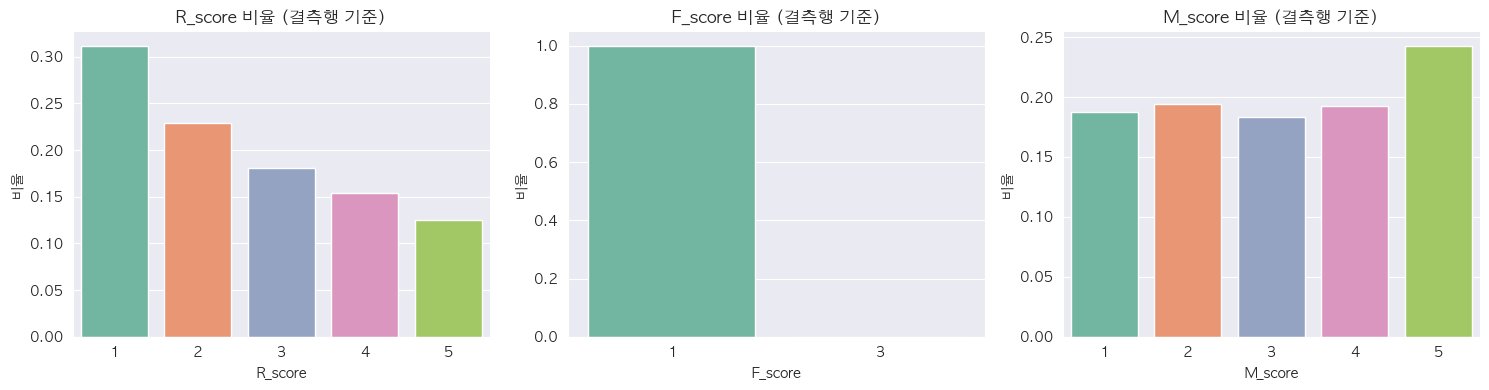

In [69]:
# 결측치 비율 시각화
plt.figure(figsize=(15, 4))
score_columns = ['R_score', 'F_score', 'M_score']

for i, col in enumerate(score_columns, 1):
    plt.subplot(1, 3, i)
    value_counts = processing_null_rows[col].value_counts(normalize=True).sort_index()  # 비율 계산
    sns.barplot(x=value_counts.index, y=value_counts.values, hue=value_counts.index, palette='Set2', legend=False)
    plt.title(f'{col} 비율 (결측행 기준)')
    plt.xlabel(col)
    plt.ylabel('비율')

plt.tight_layout()
plt.show()

In [63]:
response_null_rows = model_df[model_df['response_days'].isnull()]
print(response_null_rows)

                     customer_unique_id  Recency  Frequency  Monetary  \
44     001ae44fa04911a9e9577356dce6c63c      345          1    116.23   
290    00bee19e1199bc5cede1c674177b9e22      334          1    673.69   
380    00fb9cc86736fe3782dbc828a2eea4a6      301          1     92.57   
881    025cf7c2f32536f0be1ab412bb6602d2       62          1   1898.61   
977    02a2a0a9627a062602de754d75038ce4       70          1    532.49   
...                                 ...      ...        ...       ...   
95928  ff905cb313cb121a840dafe5a7a9170f      316          1    194.50   
95985  ffb3cbd5e1e507679e2db84c515410a5       63          1    110.63   
96022  ffca77d46c6d7d815549a5e4482dba2f      210          1    155.34   
96047  ffe0c10afc687bcf34a0451f2b87dd9b      251          1    215.76   
96055  ffe6305176b9431a3eda3cf8904d7eb7      130          1     57.37   

      Frequency_level  F_score  R_quantile  M_quantile  R_score  M_score  \
44                low        1           3     

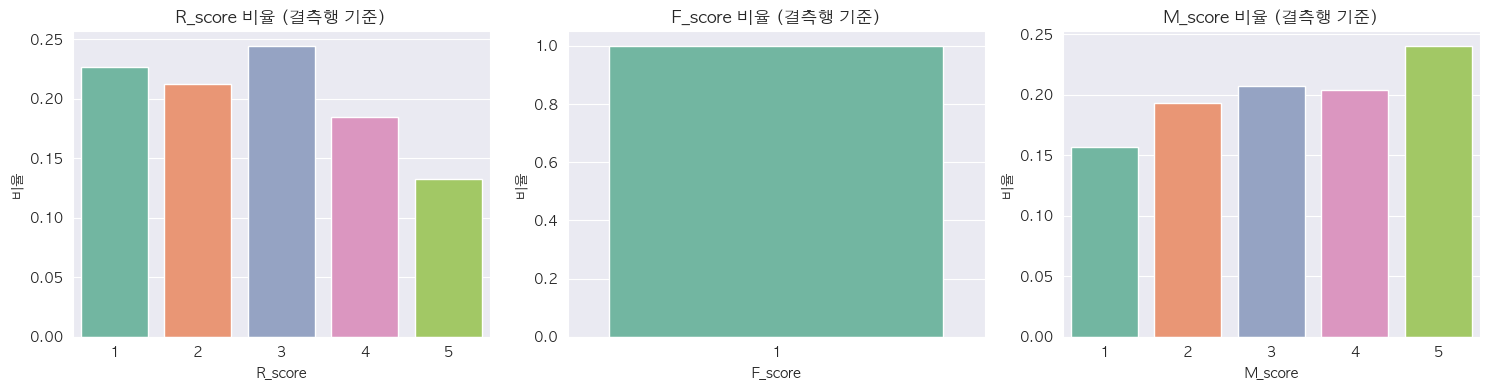

In [70]:
# 결측치 비율 시각화
plt.figure(figsize=(15, 4))
score_columns = ['R_score', 'F_score', 'M_score']

for i, col in enumerate(score_columns, 1):
    plt.subplot(1, 3, i)
    value_counts = response_null_rows[col].value_counts(normalize=True).sort_index()  # 비율 계산
    sns.barplot(x=value_counts.index, y=value_counts.values, hue=value_counts.index, palette='Set2', legend=False)
    plt.title(f'{col} 비율 (결측행 기준)')
    plt.xlabel(col)
    plt.ylabel('비율')

plt.tight_layout()
plt.show()

In [71]:
model_df.shape

(96095, 14)

In [72]:
# 결측치 포함된 행 제거 (3,343행)
model_df_cleaned = model_df.dropna()
model_df_cleaned.shape

(92752, 14)

In [73]:
model_df_cleaned.head()

,customer_unique_id,Recency,Frequency,Monetary,Frequency_level,F_score,R_quantile,M_quantile,R_score,M_score,RFM_score,churn,processing_days,response_days
0,0000366f3b9a7992bf8c76cfdf3221e2,161,1,141.90,low,1,1,3,4,4,414,0,6.0,4.0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,164,1,27.19,low,1,1,0,4,1,411,0,3.0,0.0
2,0000f46a3911fa3c0805444483337064,586,1,86.22,low,1,4,1,1,2,112,1,25.0,1.0
3,0000f6ccb0745a6a4b88665a16c9f078,370,1,43.62,low,1,3,0,2,1,211,1,20.0,1.0
4,0004aac84e0df4da2b147fca70cf8255,337,1,196.89,low,1,3,3,2,4,214,1,13.0,4.0


# SVM

In [ ]:
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# 1. Feature 및 Target 정의
X = model_df_cleaned[['Frequency', 'Monetary', 'processing_days', 'response_days']]
y = model_df_cleaned['churn']

# 2. 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 3. 파이프라인 정의 (StandardScaler + SVC)
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='rbf', probability=True, class_weight='balanced', random_state=42))
])

# 4. 하이퍼파라미터 탐색 범위
param_grid = {
    'svm__C': [0.01, 0.1, 1, 10, 100],
    'svm__gamma': [0.001, 0.01, 0.1, 1, 10]
}

# 5. 교차검증 및 GridSearchCV 정의
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=cv,
    scoring='roc_auc',  # or 'f1' based on your goal
    n_jobs=-1,
    verbose=1
)

# 6. GridSearchCV로 모델 학습
grid_search.fit(X_train, y_train)

# 7. 최적 모델 확인
print("✅ Best Parameters:", grid_search.best_params_)
print(f"🏅 Best Cross-Validated ROC AUC Score: {grid_search.best_score_:.4f}")

# 8. 최적 모델로 예측
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

# 9. 성능 평가
print("📊 [Classification Report]")
print(classification_report(y_test, y_pred))

print("📉 [Confusion Matrix]")
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.title("Confusion Matrix")
plt.show()

roc_auc = roc_auc_score(y_test, y_proba)
print(f"📈 ROC AUC Score (Test Set): {roc_auc:.4f}")

# 10. ROC Curve 시각화
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("SVM ROC Curve (Test Set)")
plt.legend()
plt.tight_layout()
plt.show()

Fitting 5 folds for each of 25 candidates, totalling 125 fits
